In [161]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import umap.umap_ as umap_
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

from sklearn.feature_extraction.text import CountVectorizer
from mpl_toolkits import mplot3d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os

In [162]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                   .Doc
                   .count()
                   .reset_index()
                   .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                   .sort_values("Size", ascending=False))
    return topic_sizes


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def map_labels_to_colors(labels):
    cmap = plt.get_cmap('brg')
    num_labels = np.max(labels) + 1
    colors = cmap(np.linspace(0, 1, num_labels))
    # print(colors)
    return colors[labels]


def gera_comparacao(list_preprossing_,cluster_):
    docs_df = pd.DataFrame(list_preprossing_,columns=["Doc"])
    docs_df['Topic'] = cluster_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic=docs_df.groupby(["Topic"],as_index=False).agg({"Doc":' '.join})
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(list_preprossing_))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
    # print(top_n_words)
    # topic_sizes = extract_topic_sizes(docs_df)
    legends=[top_n_words[i][0] for i in range(len(top_n_words))]
    return  legends


def gera_plot(result,legends):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(result.x, result.y, c=result.labels,  cmap='brg')
    plt.colorbar()
    legend_labels = [label for label in legends]
    legend_colors = map_labels_to_colors(np.arange(len(legend_labels)))
    legend_elements = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    plt.legend(handles=legend_elements)
    plt.legend(legend_elements, legend_labels)
    plt.show()


In [163]:
df_train = pd.read_excel("/home/rafael/Documentos/FACOM/Douturado/Doutorado/webcrawler/medicamentos.xlsx",index_col=0,dtype=str)
df_train.head()
list_preprossing=[]

In [164]:
for dta in range(df_train.shape[0]):
    value=str(df_train.iloc[dta,0]).lower()
    # value=str(df_train.iloc[dta,0])+" "+str(df_train.iloc[dta,1])
    # value=str(df_train.iloc[dta,0])+" "+str(df_train.iloc[dta,1]) +" "+str(df_train.iloc[dta,2])+" "+str(df_train.iloc[dta,3])
    list_preprossing.append(value)
list_preprossing=np.array(list_preprossing)
list_preprossing=list_preprossing[list_preprossing!='nan']
print(list_preprossing)

['cafeína + carisoprodol + diclofenaco sódico + paracetamol'
 'probiótico bb12 (bifidobacterium animalis subsp. lactis)'
 'enoxaparina sódica' 'cetoprofeno'
 'fosfato dissódico de dexametasona, cloridrato de tiamina, cloridrato de piridoxina, cianocobalamina'
 'drospirenona + etinilestradiol' 'ceftriaxona sódica' 'alprazolam'
 'acetato de caspofungina' 'poliestirenossulfonato de cálcio'
 'valerato de betametasona + sulfato de gentamicina + tolnaftato + clioquinol'
 'letrozol' 'tinidazol,  nitrato de miconazol' 'promestrieno'
 'losartana potássica' 'cloridrato de paroxetina' 'cloreto de sódio'
 'cloridrato de sibutramina' 'mesilato de imatinibe'
 'cloridrato de duloxetina' 'linezolida' 'desloratadina'
 'montelucaste de sódio' 'prednisolona' 'tadalafila'
 'cloridrato de venlafaxina' 'ifosfamida'
 'pantoprazol sódico sesqui-hidratado' 'topiramato'
 'cafeína + carisoprodol + diclofenaco sódico + paracetamol'
 'azitromicina' 'gestodeno + etinilestradiol' 'furoato de mometasona'
 'acetato de

In [165]:
# embedder = SentenceTransformer('distilbert-base-nli-mean-tokens',device='cuda')
embedder = SentenceTransformer('all-mpnet-base-v2',device='cuda')


In [166]:
corpus_embeddings = embedder.encode(list_preprossing,show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [207]:
tsne = TSNE(random_state = 42, n_components=2,perplexity=5,metric='cosine')
pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
umap= umap_.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')


In [208]:
embeddings2d_pca = pca.fit_transform(corpus_embeddings)
embeddings2d_tsne = tsne.fit_transform(corpus_embeddings)
embeddings2d_umap = umap.fit_transform(corpus_embeddings)
# embeddings2d_lda = lda.fit_transform(corpus_embeddings,list_preprossing)


In [169]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(embeddings2d_tsne)

In [170]:
# result = pd.DataFrame(embeddings2d_tsne, columns=['x', 'y'])
# result['labels'] = cluster.labels_
# fig, ax = plt.subplots(figsize=(20, 10))
# outliers = result.loc[result.labels == -1, :]
# clustered = result.loc[result.labels != -1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
# plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
# plt.colorbar()

In [209]:
embeddings2d_ =embeddings2d_tsne

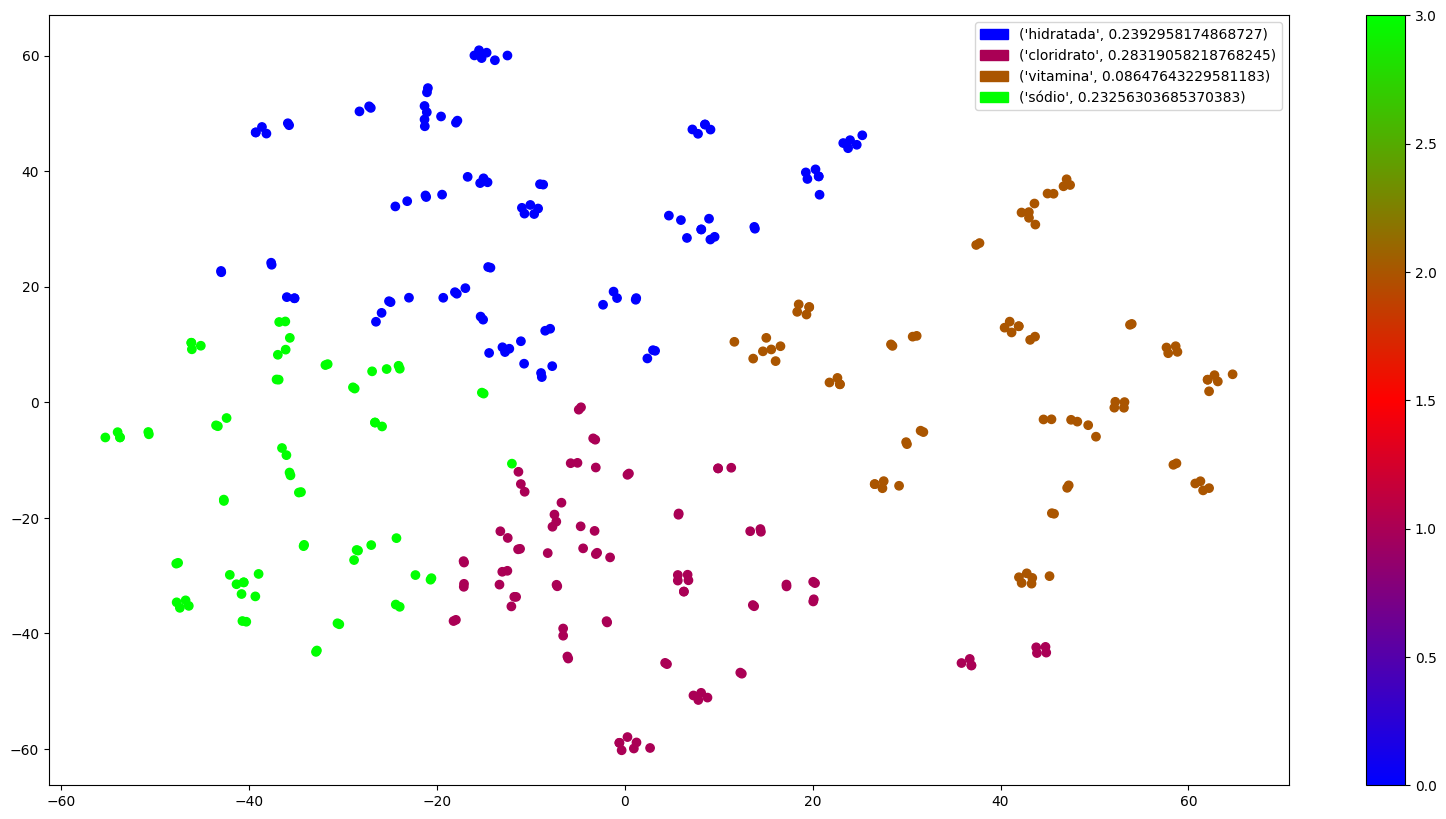

[('hidratada', 0.2392958174868727), ('cloridrato', 0.28319058218768245), ('vitamina', 0.08647643229581183), ('sódio', 0.23256303685370383)]


In [210]:
knn_4 = KMeans(n_clusters=4,n_init=40)
modelo_knn_3 = knn_4.fit_predict(embeddings2d_)
result = pd.DataFrame(embeddings2d_, columns=['x', 'y'])
result['labels'] = modelo_knn_3
labels = gera_comparacao(list_preprossing,modelo_knn_3)
gera_plot(result,labels)
print(labels)

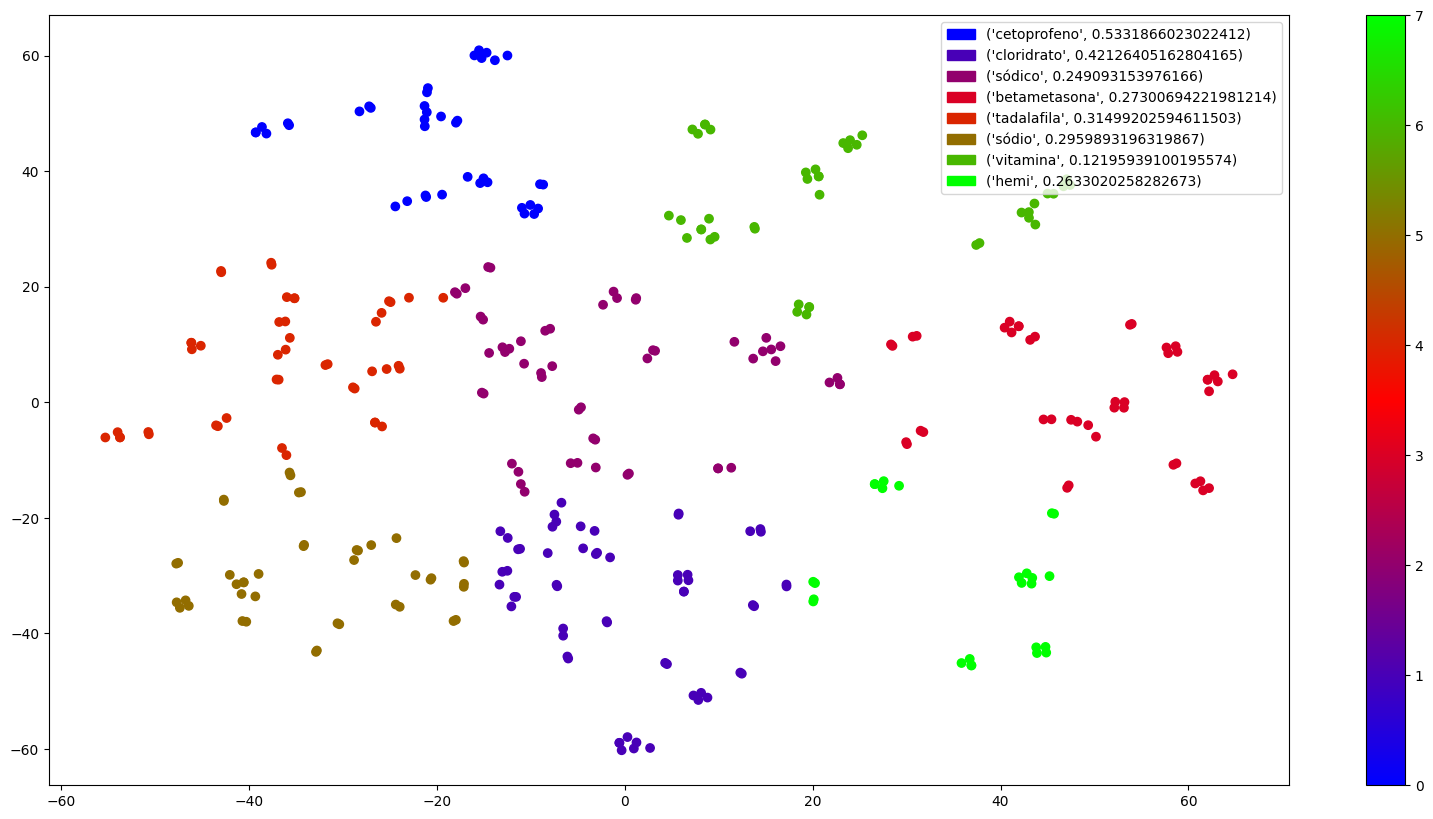

In [211]:
knn_4 = KMeans(n_clusters=8,n_init=40)
modelo_knn_4 = knn_4.fit_predict(embeddings2d_)
result = pd.DataFrame(embeddings2d_, columns=['x', 'y'])
result['labels'] = modelo_knn_4
labels = gera_comparacao(list_preprossing,modelo_knn_4)
gera_plot(result,labels)

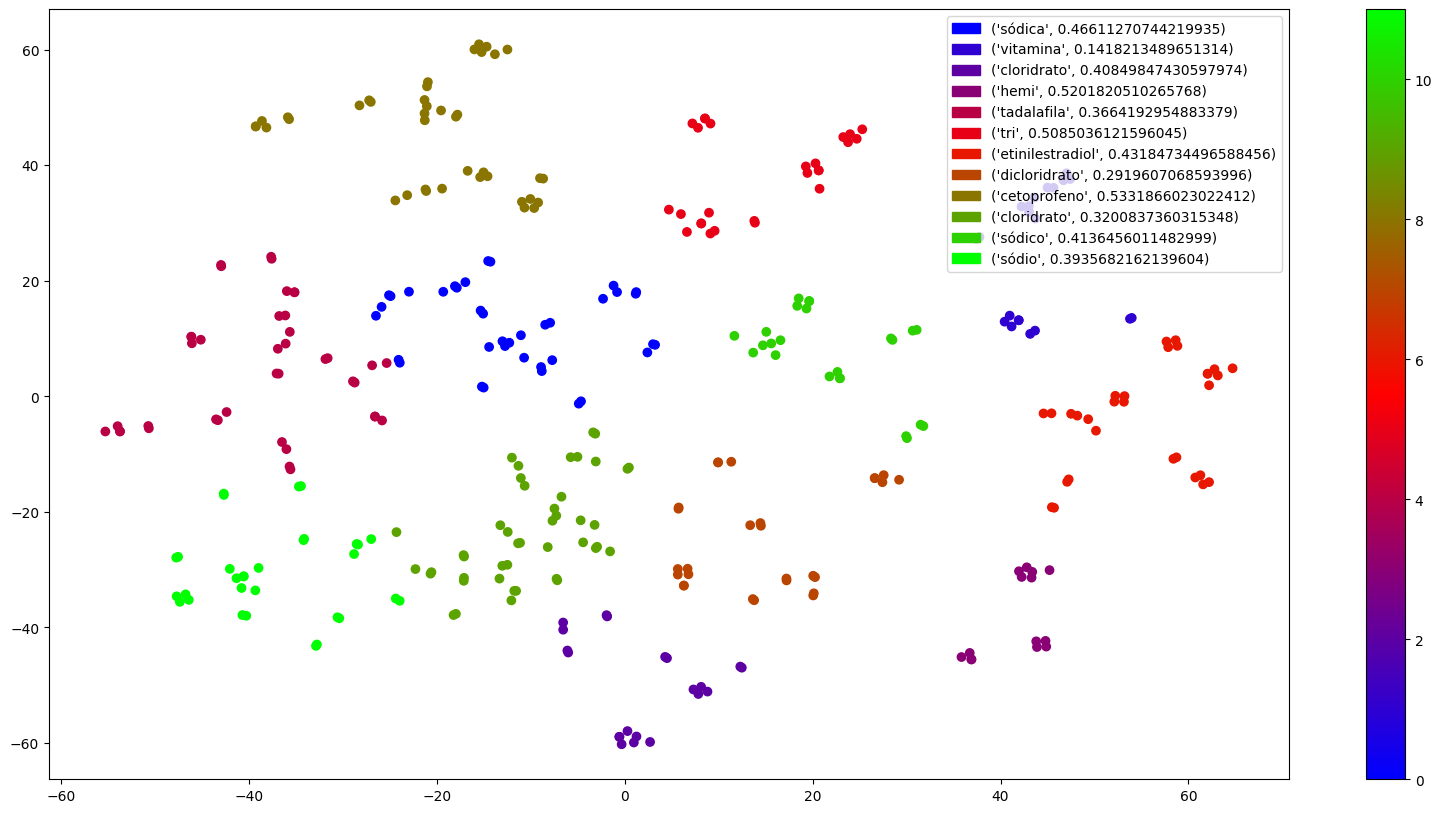

In [212]:
knn_4 = KMeans(n_clusters=12,n_init=40)
modelo_knn_4 = knn_4.fit_predict(embeddings2d_)
result = pd.DataFrame(embeddings2d_, columns=['x', 'y'])
result['labels'] = modelo_knn_4
labels = gera_comparacao(list_preprossing,modelo_knn_4)
# print(labels)
gera_plot(result,labels)

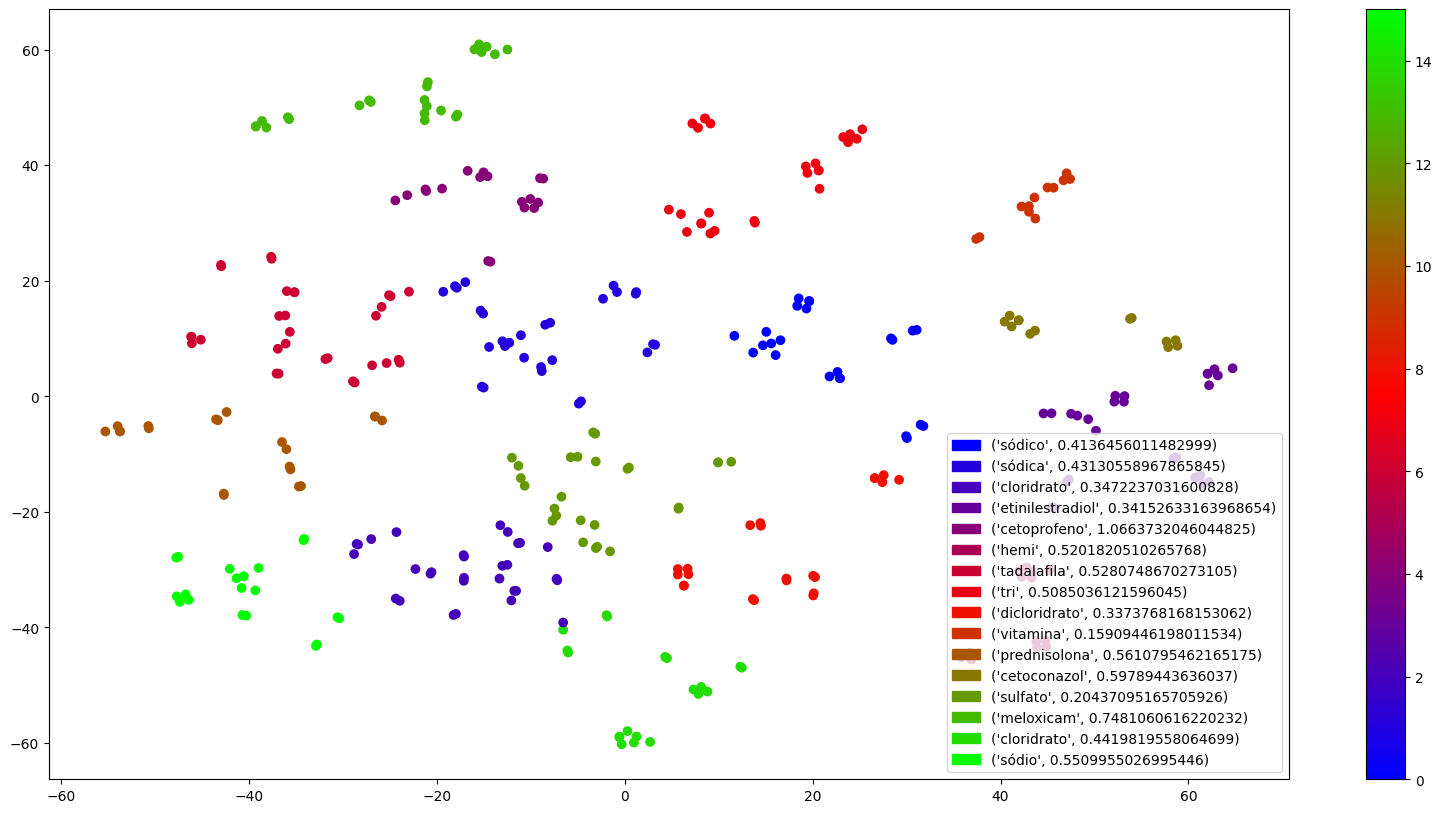

In [213]:
knn_4 = KMeans(n_clusters=16,n_init=40)
modelo_knn_4 = knn_4.fit_predict(embeddings2d_)
result = pd.DataFrame(embeddings2d_, columns=['x', 'y'])
result['labels'] = modelo_knn_4
labels = gera_comparacao(list_preprossing,modelo_knn_4)
# print(labels)
gera_plot(result,labels)